# Continuous Normalising Flow

This example is a bit of fun! It constructs a [continuous normalising flow](https://arxiv.org/abs/1810.01367) (CNF) to learn a distribution specified by a (greyscale) image. That is, the target distribution is over $\mathbb{R}^2$, and the image specifies the (unnormalised) density at each point.

You can specify your own images, and learn your own flows.

Some example outputs from this script:

![cat](../imgs/target-progression.png)
![cat](../imgs/cat-progression.png)
![cat](../imgs/butterfly-progression.png)

**Reference:**

```bibtex
@article{grathwohl2019ffjord,
    title={{FFJORD}: {F}ree-form {C}ontinuous {D}ynamics for {S}calable {R}eversible
           {G}enerative {M}odels},
    author={Grathwohl, Will and Chen, Ricky T. Q. and Bettencourt, Jesse and
            Sutskever, Ilya and Duvenaud, David},
    journal={International Conference on Learning Representations},
    year={2019},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/docs/examples/continuous_normalising_flow.ipynb).

!!! warning

    This example will need a GPU to run efficiently.

!!! danger "Advanced example"

    This is a pretty advanced example.

In [ ]:
import math
import os
import pathlib
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import imageio
import jax
import jax.lax as lax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import scipy.stats as stats


here = pathlib.Path(os.getcwd())

First let's define some vector fields. This is basically just an MLP, using tanh as the activation function and "ConcatSquash" instead of linear layers.

This is the vector field on the right hand side of the ODE.

In [2]:
class Func(eqx.Module):
    layers: list[eqx.nn.Linear]

    def __init__(self, *, data_size, width_size, depth, key, **kwargs):
        super().__init__(**kwargs)
        keys = jr.split(key, depth + 1)
        layers = []
        if depth == 0:
            layers.append(
                ConcatSquash(in_size=data_size, out_size=data_size, key=keys[0])
            )
        else:
            layers.append(
                ConcatSquash(in_size=data_size, out_size=width_size, key=keys[0])
            )
            for i in range(depth - 1):
                layers.append(
                    ConcatSquash(
                        in_size=width_size, out_size=width_size, key=keys[i + 1]
                    )
                )
            layers.append(
                ConcatSquash(in_size=width_size, out_size=data_size, key=keys[-1])
            )
        self.layers = layers

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = jnn.tanh(y)
        y = self.layers[-1](t, y)
        return y


# Credit: this layer, and some of the default hyperparameters below, are taken from the
# FFJORD repo.
class ConcatSquash(eqx.Module):
    lin1: eqx.nn.Linear
    lin2: eqx.nn.Linear
    lin3: eqx.nn.Linear

    def __init__(self, *, in_size, out_size, key, **kwargs):
        super().__init__(**kwargs)
        key1, key2, key3 = jr.split(key, 3)
        self.lin1 = eqx.nn.Linear(in_size, out_size, key=key1)
        self.lin2 = eqx.nn.Linear(1, out_size, key=key2)
        self.lin3 = eqx.nn.Linear(1, out_size, use_bias=False, key=key3)

    def __call__(self, t, y):
        return self.lin1(y) * jnn.sigmoid(self.lin2(t)) + self.lin3(t)

When training, we need to wrap our vector fields in something that also computes the change in log-density.

This can be done either approximately (using Hutchinson's trace estimator) or exactly (the divergence of the vector field; relatively computationally expensive).

In [3]:
def approx_logp_wrapper(t, y, args):
    y, _ = y
    *args, eps, func = args
    fn = lambda y: func(t, y, args)
    f, vjp_fn = jax.vjp(fn, y)
    (eps_dfdy,) = vjp_fn(eps)
    logp = jnp.sum(eps_dfdy * eps)
    return f, logp


def exact_logp_wrapper(t, y, args):
    y, _ = y
    *args, _, func = args
    fn = lambda y: func(t, y, args)
    f, vjp_fn = jax.vjp(fn, y)
    (size,) = y.shape  # this implementation only works for 1D input
    eye = jnp.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = jnp.trace(dfdy)
    return f, logp

Wrap up the differential equation solve into a model.

In [4]:
def normal_log_likelihood(y):
    return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))


class CNF(eqx.Module):
    funcs: list[Func]
    data_size: int
    exact_logp: bool
    t0: float
    t1: float
    dt0: float

    def __init__(
        self,
        *,
        data_size,
        exact_logp,
        num_blocks,
        width_size,
        depth,
        key,
        **kwargs,
    ):
        super().__init__(**kwargs)
        keys = jr.split(key, num_blocks)
        self.funcs = [
            Func(
                data_size=data_size,
                width_size=width_size,
                depth=depth,
                key=k,
            )
            for k in keys
        ]
        self.data_size = data_size
        self.exact_logp = exact_logp
        self.t0 = 0.0
        self.t1 = 0.5
        self.dt0 = 0.05

    # Runs backward-in-time to train the CNF.
    def train(self, y, *, key):
        if self.exact_logp:
            term = diffrax.ODETerm(exact_logp_wrapper)
        else:
            term = diffrax.ODETerm(approx_logp_wrapper)
        solver = diffrax.Tsit5()
        eps = jr.normal(key, y.shape)
        delta_log_likelihood = 0.0
        for func in reversed(self.funcs):
            y = (y, delta_log_likelihood)
            sol = diffrax.diffeqsolve(
                term, solver, self.t1, self.t0, -self.dt0, y, (eps, func)
            )
            (y,), (delta_log_likelihood,) = sol.ys
        return delta_log_likelihood + normal_log_likelihood(y)

    # Runs forward-in-time to draw samples from the CNF.
    def sample(self, *, key):
        y = jr.normal(key, (self.data_size,))
        for func in self.funcs:
            term = diffrax.ODETerm(func)
            solver = diffrax.Tsit5()
            sol = diffrax.diffeqsolve(term, solver, self.t0, self.t1, self.dt0, y)
            (y,) = sol.ys
        return y

    # To make illustrations, we have a variant sample method we can query to see the
    # evolution of the samples during the forward solve.
    def sample_flow(self, *, key):
        t_so_far = self.t0
        t_end = self.t0 + (self.t1 - self.t0) * len(self.funcs)
        save_times = jnp.linspace(self.t0, t_end, 6)
        y = jr.normal(key, (self.data_size,))
        out = []
        for i, func in enumerate(self.funcs):
            if i == len(self.funcs) - 1:
                save_ts = save_times[t_so_far <= save_times] - t_so_far
            else:
                save_ts = (
                    save_times[
                        (t_so_far <= save_times)
                        & (save_times < t_so_far + self.t1 - self.t0)
                    ]
                    - t_so_far
                )
                t_so_far = t_so_far + self.t1 - self.t0
            term = diffrax.ODETerm(func)
            solver = diffrax.Tsit5()
            saveat = diffrax.SaveAt(ts=save_ts)
            sol = diffrax.diffeqsolve(
                term, solver, self.t0, self.t1, self.dt0, y, saveat=saveat
            )
            out.append(sol.ys)
            y = sol.ys[-1]
        out = jnp.concatenate(out)
        assert len(out) == 6  # number of points we saved at
        return out

Alright, that's the models done. Now let's get some data.

First we have a function for taking the specified input image, and turning it into data.

In [5]:
def get_data(path):
    # integer array of shape (height, width, channels) with values in {0, ..., 255}
    img = jnp.asarray(imageio.imread(path))
    if img.shape[-1] == 4:
        img = img[..., :-1]  # ignore alpha channel
    height, width, channels = img.shape
    assert channels == 3
    # Convert to greyscale for simplicity.
    img = img @ jnp.array([0.2989, 0.5870, 0.1140])
    img = jnp.transpose(img)[:, ::-1]  # (width, height)
    x = jnp.arange(width, dtype=jnp.float32)
    y = jnp.arange(height, dtype=jnp.float32)
    x, y = jnp.broadcast_arrays(x[:, None], y[None, :])
    weights = 1 - img.reshape(-1).astype(jnp.float32) / jnp.max(img)
    dataset = jnp.stack(
        [x.reshape(-1), y.reshape(-1)], axis=-1
    )  # shape (dataset_size, 2)
    # For efficiency we don't bother with the particles that will have weight zero.
    cond = img.reshape(-1) < 254
    dataset = dataset[cond]
    weights = weights[cond]
    mean = jnp.mean(dataset, axis=0)
    std = jnp.std(dataset, axis=0) + 1e-6
    dataset = (dataset - mean) / std

    return dataset, weights, mean, std, img, width, height

Now to load the data during training, we need a dataloader. In this case our dataset is small enough to fit in-memory, so we use a dataloader implementation that we can include within our overall JIT wrapper, for speed.

In [6]:
class DataLoader(eqx.Module):
    arrays: tuple[jnp.ndarray, ...]
    batch_size: int
    key: jr.PRNGKey

    def __check_init__(self):
        dataset_size = self.arrays[0].shape[0]
        assert all(array.shape[0] == dataset_size for array in self.arrays)

    def __call__(self, step):
        dataset_size = self.arrays[0].shape[0]
        num_batches = dataset_size // self.batch_size
        epoch = step // num_batches
        key = jr.fold_in(self.key, epoch)
        perm = jr.permutation(key, jnp.arange(dataset_size))
        start = (step % num_batches) * self.batch_size
        slice_size = self.batch_size
        batch_indices = lax.dynamic_slice_in_dim(perm, start, slice_size)
        return tuple(array[batch_indices] for array in self.arrays)

Bring everything together. This function is our entry point.

In [7]:
def main(
    in_path,
    out_path=None,
    batch_size=500,
    virtual_batches=2,
    lr=1e-3,
    weight_decay=1e-5,
    steps=10000,
    exact_logp=True,
    num_blocks=2,
    width_size=64,
    depth=3,
    print_every=100,
    seed=5678,
):
    if out_path is None:
        out_path = here / pathlib.Path(in_path).name
    else:
        out_path = pathlib.Path(out_path)

    key = jr.PRNGKey(seed)
    model_key, loader_key, loss_key, sample_key = jr.split(key, 4)

    dataset, weights, mean, std, img, width, height = get_data(in_path)
    dataset_size, data_size = dataset.shape
    dataloader = DataLoader((dataset, weights), batch_size, key=loader_key)

    model = CNF(
        data_size=data_size,
        exact_logp=exact_logp,
        num_blocks=num_blocks,
        width_size=width_size,
        depth=depth,
        key=model_key,
    )

    optim = optax.adamw(lr, weight_decay=weight_decay)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    @eqx.filter_value_and_grad
    def loss(model, data, weight, loss_key):
        batch_size, _ = data.shape
        noise_key, train_key = jr.split(loss_key, 2)
        train_key = jr.split(train_key, batch_size)
        data = data + jr.normal(noise_key, data.shape) * 0.5 / std
        log_likelihood = jax.vmap(model.train)(data, key=train_key)
        return -jnp.mean(weight * log_likelihood)  # minimise negative log-likelihood

    @eqx.filter_jit
    def make_step(model, opt_state, step, loss_key):
        # We only need gradients with respect to floating point JAX arrays, not any
        # other part of our model. (e.g. the `exact_logp` flag. What would it even mean
        # to differentiate that? Note that `eqx.filter_value_and_grad` does the same
        # filtering by `eqx.is_inexact_array` by default.)
        value = 0
        grads = jax.tree_util.tree_map(
            lambda leaf: jnp.zeros_like(leaf) if eqx.is_inexact_array(leaf) else None,
            model,
        )

        # Get more accurate gradients by accumulating gradients over multiple batches.
        # (Or equivalently, get lower memory requirements by splitting up a batch over
        # multiple steps.)
        def make_virtual_step(_, state):
            value, grads, step, loss_key = state
            data, weight = dataloader(step)
            value_, grads_ = loss(model, data, weight, loss_key)
            value = value + value_
            grads = jax.tree_util.tree_map(lambda a, b: a + b, grads, grads_)
            step = step + 1
            loss_key = jr.split(loss_key, 1)[0]
            return value, grads, step, loss_key

        value, grads, step, loss_key = lax.fori_loop(
            0, virtual_batches, make_virtual_step, (value, grads, step, loss_key)
        )
        value = value / virtual_batches
        grads = jax.tree_util.tree_map(lambda a: a / virtual_batches, grads)
        updates, opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_inexact_array)
        )
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state, step, loss_key

    step = 0
    while step < steps:
        start = time.time()
        value, model, opt_state, step, loss_key = make_step(
            model, opt_state, step, loss_key
        )
        end = time.time()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {value}, Computation time: {end - start}")

    num_samples = 5000
    sample_key = jr.split(sample_key, num_samples)
    samples = jax.vmap(model.sample)(key=sample_key)
    sample_flows = jax.vmap(model.sample_flow, out_axes=-1)(key=sample_key)
    fig, (*axs, ax, axtrue) = plt.subplots(
        1,
        2 + len(sample_flows),
        figsize=((2 + len(sample_flows)) * 10 * height / width, 10),
    )

    samples = samples * std + mean
    x = samples[:, 0]
    y = samples[:, 1]
    ax.scatter(x, y, c="black", s=2)
    ax.set_xlim(-0.5, width - 0.5)
    ax.set_ylim(-0.5, height - 0.5)
    ax.set_aspect(height / width)
    ax.set_xticks([])
    ax.set_yticks([])

    axtrue.imshow(img.T, origin="lower", cmap="gray")
    axtrue.set_aspect(height / width)
    axtrue.set_xticks([])
    axtrue.set_yticks([])

    x_resolution = 100
    y_resolution = int(x_resolution * (height / width))
    sample_flows = sample_flows * std[:, None] + mean[:, None]
    x_pos, y_pos = jnp.broadcast_arrays(
        jnp.linspace(-1, width + 1, x_resolution)[:, None],
        jnp.linspace(-1, height + 1, y_resolution)[None, :],
    )
    positions = jnp.stack([jnp.ravel(x_pos), jnp.ravel(y_pos)])
    densities = [stats.gaussian_kde(samples)(positions) for samples in sample_flows]
    for i, (ax, density) in enumerate(zip(axs, densities)):
        density = jnp.reshape(density, (x_resolution, y_resolution))
        ax.imshow(density.T, origin="lower", cmap="plasma")
        ax.set_aspect(height / width)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(out_path)
    plt.show()

And now the following commands will reproduce the images displayed at the start.

```python
main(in_path="../imgs/cat.png")
main(in_path="../imgs/butterfly.png", num_blocks=3)
main(in_path="../imgs/target.png", width_size=128)
```

Let's run the first one of those as a demonstration.

Step: 100, Loss: 1.326553225517273, Computation time: 0.005589962005615234
Step: 200, Loss: 1.2921397686004639, Computation time: 0.004528999328613281
Step: 300, Loss: 1.2790848016738892, Computation time: 0.004530906677246094
Step: 400, Loss: 1.244489073753357, Computation time: 0.004511833190917969
Step: 500, Loss: 1.235985517501831, Computation time: 0.004565000534057617
Step: 600, Loss: 1.202713966369629, Computation time: 0.004781961441040039
Step: 700, Loss: 1.2291572093963623, Computation time: 0.00454401969909668
Step: 800, Loss: 1.1679149866104126, Computation time: 0.0047419071197509766
Step: 900, Loss: 1.2050381898880005, Computation time: 0.004331111907958984
Step: 1000, Loss: 1.1861329078674316, Computation time: 0.0062639713287353516
Step: 1100, Loss: 1.1747440099716187, Computation time: 0.004642963409423828
Step: 1200, Loss: 1.2095255851745605, Computation time: 0.0046939849853515625
Step: 1300, Loss: 1.1605581045150757, Computation time: 0.004503011703491211
Step: 1400

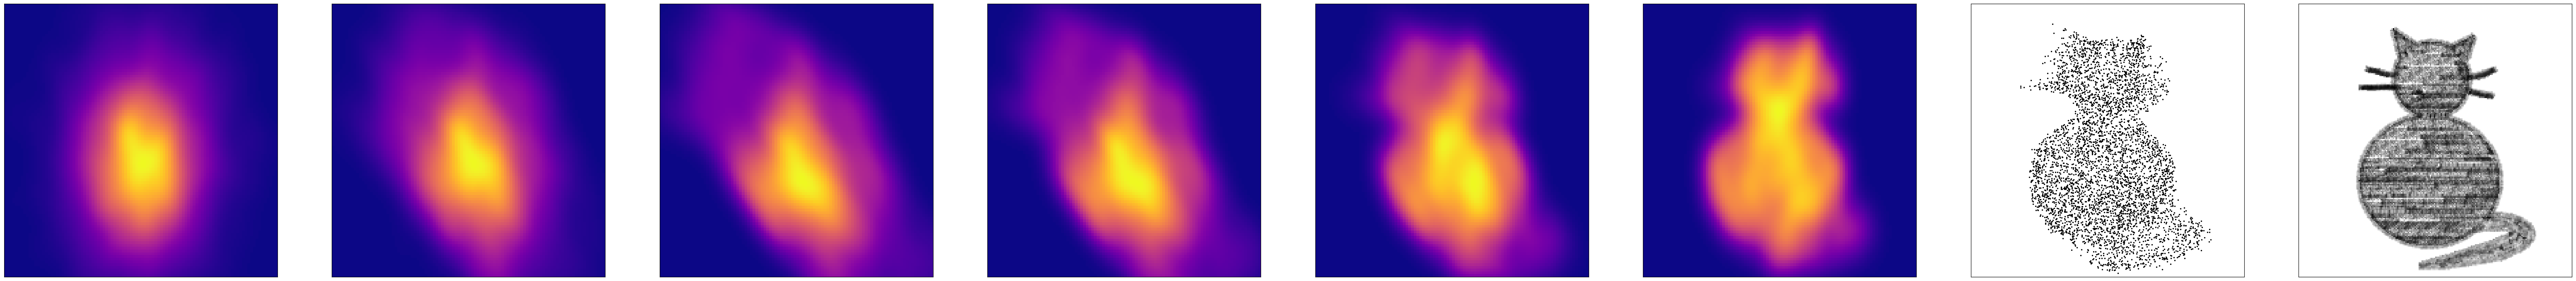

In [8]:
main(in_path="../imgs/cat.png")